In [140]:
### Things I would do if I had more time:
# Combine different metrics to calculate new metrics that could be better associated with interest_rate.
#   This could include calculating poor loan appraisal or using more of the "unverified" loan information. 
# I ran into issues when running my Logistic Regression.  The reason for it was that the values were floats, 
#   meaning that they contained many decimals.  To quickly fix this issue, I switched the type to int's so I could run the Regression.
#   This is not good practice, considering now the values are estimated, leading to worse predictive results.

import pandas as pd
import numpy as np

import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv('loans_full_schema.csv')

data.isna().sum()

# Some issues I am having with the overall dataset is the number of 'NA' values in some of the metrics.  
# For instance, all of the 'joint' metrics had 8500+ out of their 10000 values be NA, making the columns seem useless.

# Another issue I had with the data is that most of the data was categorical, meaning it was harder to find correlations 
# without segmenting/clustering the data into separate groups.

# A final issue I noticed is the sheer number of metrics to deal with, so I want to try to consider only the necessary metrics
# that will be useful for predicting interest rates.  I took out all columns that I thought was either irrelevant or messy.

emp_title                            833
emp_length                           817
state                                  0
homeownership                          0
annual_income                          0
verified_income                        0
debt_to_income                        24
annual_income_joint                 8505
verification_income_joint           8545
debt_to_income_joint                8505
delinq_2y                              0
months_since_last_delinq            5658
earliest_credit_line                   0
inquiries_last_12m                     0
total_credit_lines                     0
open_credit_lines                      0
total_credit_limit                     0
total_credit_utilized                  0
num_collections_last_12m               0
num_historical_failed_to_pay           0
months_since_90d_late               7715
current_accounts_delinq                0
total_collection_amount_ever           0
current_installment_accounts           0
accounts_opened_

In [87]:
cleaner_data = data.drop(['emp_title', 'emp_length', 'verified_income', 'annual_income_joint', 'verification_income_joint', 
                         'debt_to_income_joint', 'months_since_last_delinq', 'months_since_90d_late'], axis=1)
cleaner_data.head()

,state,homeownership,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,NJ,MORTGAGE,90000.0,18.01,0,2001,6,28,10,70795,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,HI,RENT,40000.0,5.04,0,1996,1,30,14,28800,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,WI,RENT,40000.0,21.15,0,2006,4,31,10,24193,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,PA,RENT,30000.0,10.16,0,2007,0,4,4,25400,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,CA,RENT,35000.0,57.96,0,2008,7,22,16,69839,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [129]:
# debt_to_income only has 24 NA values out of 10000, so We will use annual_income and total_debt_limit
# along with a RandomForest to impute these values


## First, We will sample 75% of the data as training, and the rest as will be our testing set.  
# Since this is not time series data, We will do it randomly
# We will use our cleaned-up dataset
train = cleaner_data.sample(frac = .75)
test = cleaner_data.drop(train.index)


#Now, we will train on the latter and make 'predictions' on the null data to impute debt_to_income using a RandomForest 
# regression algorithm with the variables 'annual_income' and 'total_collection_amount_ever'
#  I chose these variables because I wanted one variable that was correlated to debt, and one correlated with income.

train_no_nulls = train.dropna(subset = ['debt_to_income'])
train_nulls = train.drop(train_no_nulls.index)

x = ['annual_income','total_collection_amount_ever']

forestModel = RandomForestRegressor()
forestModel.fit(train_no_nulls[x], train_no_nulls['debt_to_income'])

values = forestModel.predict(X = train_nulls[x])

train_nulls['debt_to_income'] = values.astype(int)

trained = train_no_nulls.append(train_nulls)

trained.describe()

,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,...,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,7.874908e+04,19.683552,0.213600,2001.290000,1.939467,22.698133,11.428400,1.828484e+05,51067.630933,0.014400,...,0.124667,16318.863333,43.248000,12.451269,475.521517,14392.861745,2521.194938,1920.015055,601.061396,0.118477
std,6.401262e+04,17.236427,0.660732,7.724799,2.363898,11.948575,5.884751,1.887932e+05,53798.422727,0.128821,...,0.337945,10318.843511,11.019741,5.030105,296.138791,9984.358926,4017.399986,3948.560039,520.008470,1.832924
min,0.000000e+00,0.000000,0.000000,1963.000000,0.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,1000.000000,36.000000,5.310000,30.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.500000e+04,11.057500,0.000000,1997.000000,0.000000,14.000000,7.000000,5.092400e+04,18959.000000,0.000000,...,0.000000,8000.000000,36.000000,9.430000,256.040000,6638.305000,926.745000,584.695000,218.377500,0.000000
50%,6.500000e+04,17.600000,0.000000,2003.000000,1.000000,21.000000,10.000000,1.147350e+05,36927.000000,0.000000,...,0.000000,14400.000000,36.000000,11.980000,397.345000,12308.745000,1563.300000,986.505000,445.645000,0.000000
75%,9.500000e+04,25.010000,0.000000,2006.000000,3.000000,29.000000,14.000000,2.663885e+05,65725.500000,0.000000,...,0.000000,23818.750000,60.000000,15.050000,644.600000,20455.315000,2637.000000,1710.757500,826.550000,0.000000
max,2.300000e+06,469.090000,10.000000,2015.000000,29.000000,87.000000,51.000000,3.386034e+06,942456.000000,3.000000,...,3.000000,40000.000000,60.000000,30.940000,1546.520000,40000.000000,41630.443684,40000.000000,4216.440000,52.980000


In [130]:
### This is the second part to imputing debt_to_income.  We will now take our predictions from the training set, and apply it 
# to the testing set, or the other 25% of our data.

test_no_nulls = test.dropna(subset = ['debt_to_income'])
test_nulls = test.drop(test_no_nulls.index)

# Train on the latter and make 'predictions' on the null data to impute monthly_income using a regression algorithm
# with the variables 'number_real_estate_loans_or_lines' and 'number_of_open_credit_lines_and_loans'

forestModel2 = RandomForestRegressor()
forestModel2.fit(test_no_nulls[x], test_no_nulls['debt_to_income'])

values2 = forestModel.predict(X = test_nulls[x])

test_nulls['debt_to_income'] = values2.astype(int)

tested = test_no_nulls.append(test_nulls)

tested.describe()


####  NOTE: The reasoning for all of these steps to impute debt_to_income is that We do not want to create any data leaks/
# bias when we end up visualizing the data and running our algorithms to predict interest_rate

# Now, we have testing and training data all set up to use for our algorithms We will run later whe We 
# try to predict interest_rate!  We will look at these sets of data later...

,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,...,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,8.064135e+04,19.781952,0.223200,2001.290000,2.014400,22.624000,11.332400,1.858797e+05,50993.359600,0.012000,...,0.121200,16491.100000,43.344000,12.356288,478.256740,14657.081204,2413.354278,1817.748700,595.482936,0.122632
std,6.684557e+04,16.548830,0.748335,8.005469,2.427787,11.696176,5.819163,1.841259e+05,53159.364539,0.119422,...,0.334896,10252.101761,11.062125,4.913384,291.005059,9904.278878,3774.785916,3684.954002,509.282228,1.754160
min,0.000000e+00,0.000000,0.000000,1963.000000,0.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,1000.000000,36.000000,5.310000,31.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.654200e+04,11.170000,0.000000,1998.000000,0.000000,14.000000,7.000000,5.260075e+04,19800.250000,0.000000,...,0.000000,8400.000000,36.000000,9.430000,256.590000,6962.720000,935.555000,592.632500,225.827500,0.000000
50%,6.500000e+04,17.615000,0.000000,2003.000000,1.000000,21.000000,10.000000,1.140800e+05,36889.500000,0.000000,...,0.000000,15000.000000,36.000000,11.980000,400.445000,12680.155000,1562.900000,984.015000,446.975000,0.000000
75%,9.770000e+04,25.265000,0.000000,2006.000000,3.000000,29.000000,14.000000,2.704785e+05,64391.750000,0.000000,...,0.000000,24000.000000,60.000000,15.050000,644.877500,20955.280000,2584.145000,1648.970000,818.555000,0.000000
max,1.200000e+06,267.550000,13.000000,2015.000000,22.000000,87.000000,46.000000,1.794551e+06,797760.000000,2.000000,...,2.000000,40000.000000,60.000000,30.790000,1566.590000,39308.290000,41405.578794,40000.000000,4206.180000,44.480000


In [103]:
renters = cleaner_data.loc[data['homeownership'] == 'RENT']
renters.head()

,state,homeownership,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
1,HI,RENT,40000.0,5.04,0,1996,1,30,14,28800,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,WI,RENT,40000.0,21.15,0,2006,4,31,10,24193,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,PA,RENT,30000.0,10.16,0,2007,0,4,4,25400,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,CA,RENT,35000.0,57.96,0,2008,7,22,16,69839,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0
9,IL,RENT,30000.0,18.91,0,2001,0,9,6,33114,...,A3,Mar-2018,Current,fractional,Cash,6077.13,391.15,322.87,68.28,0.0


In [195]:
### The first plot is interactive, meaning that I can change the x and y axis to whatever metrics I want.  
# This helps me see any interesting trends between two specific metrics more effectively

import plotly.graph_objects as go
import plotly.express as px

from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact, Layout

def multiplot(xaxis, yaxis):
    fig = px.scatter(renters, x=xaxis, y=yaxis, width=1300, height=650)
    fig.update_layout(title_text="Loan Data",)
    fig.show()

interactive(multiplot, xaxis=list(cleaner_data.columns), yaxis=list(cleaner_data.columns)[2:])

interactive(children=(Dropdown(description='xaxis', options=('state', 'homeownership', 'annual_income', 'debt_…

In [93]:
### For my first visualization, I noticed that the outliers contained within the dataset are 
###   typically when the lenders have a Mortgage rather than rent or own their homes (as shown by color of the dots)
###   Let's try to find tends specifically within this outlying data.


fig = px.scatter_matrix(data, dimensions=['annual_income', 'months_since_90d_late', 'total_credit_lines', 'loan_amount', 'interest_rate'], width=1300, height=650,
                        color = 'homeownership', color_continuous_scale=px.colors.diverging.Tealrose)
fig.update_layout(title_text="Loan Data")
fig.show()


In [111]:
mort = cleaner_data.loc[data['homeownership'] == 'MORTGAGE']

fig = px.box(mort, x="grade", y="interest_rate", color="loan_status",
color_discrete_sequence=px.colors.qualitative.Dark24,
labels={col:col.replace('_', ' ') for col in data.columns},
category_orders={"grade":["A","B","C","D","E","F","G"]})
fig.update_layout(legend=dict(orientation="h", yanchor="bottom",
y=1.02, xanchor="right", x=1))
fig.show()

[Text(0.5, 0, 'annual_income'),
 Text(2.5, 0, 'delinq_2y'),
 Text(4.5, 0, 'inquiries_last_12m'),
 Text(6.5, 0, 'open_credit_lines'),
 Text(8.5, 0, 'total_credit_utilized'),
 Text(10.5, 0, 'num_historical_failed_to_pay'),
 Text(12.5, 0, 'total_collection_amount_ever'),
 Text(14.5, 0, 'accounts_opened_24m'),
 Text(16.5, 0, 'num_satisfactory_accounts'),
 Text(18.5, 0, 'num_accounts_30d_past_due'),
 Text(20.5, 0, 'total_debit_limit'),
 Text(22.5, 0, 'num_open_cc_accounts'),
 Text(24.5, 0, 'num_mort_accounts'),
 Text(26.5, 0, 'tax_liens'),
 Text(28.5, 0, 'loan_amount'),
 Text(30.5, 0, 'interest_rate'),
 Text(32.5, 0, 'balance'),
 Text(34.5, 0, 'paid_principal'),
 Text(36.5, 0, 'paid_late_fees')]

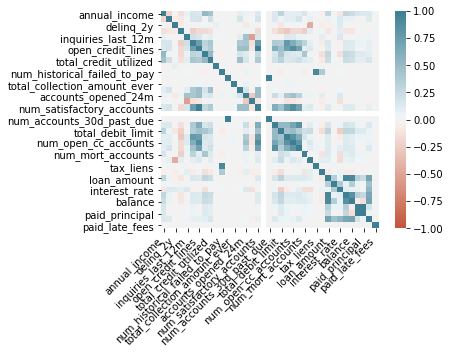

In [101]:
import seaborn as sns

corr = mort.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


In [141]:
trained.columns


Index(['state', 'homeownership', 'annual_income', 'debt_to_income',
       'delinq_2y', 'earliest_credit_line', 'inquiries_last_12m',
       'total_credit_lines', 'open_credit_lines', 'total_credit_limit',
       'total_credit_utilized', 'num_collections_last_12m',
       'num_historical_failed_to_pay', 'current_accounts_delinq',
       'total_collection_amount_ever', 'current_installment_accounts',
       'accounts_opened_24m', 'months_since_last_credit_inquiry',
       'num_satisfactory_accounts', 'num_accounts_120d_past_due',
       'num_accounts_30d_past_due', 'num_active_debit_accounts',
       'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts',
       'num_cc_carrying_balance', 'num_mort_accounts',
       'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt',
       'loan_purpose', 'application_type', 'loan_amount', 'term',
       'interest_rate', 'installment', 'grade', 'sub_grade', 'issue_month',
       'loan_status', 'initial_listing_status', 

In [158]:
### Algorithm I -> Logistic Regression

# For my first algorithm, I want to use a logistic regression using any relevant metrics I think may have an impact 
# on interest_rate.  Some things I am considering is to create "dummy variables" for my categorical variables so that I can 
# include them in the algorithm.  Due to time constraints, I may pass up on this unfortunately.

# Instead, I will make a subset of the original Trained Set which will include only quantitative metrics.
log_x = trained[['annual_income', 'debt_to_income', 'delinq_2y', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines',
                    'total_credit_limit', 'total_credit_utilized', 'num_collections_last_12m',
                       'num_historical_failed_to_pay', 'current_accounts_delinq',
                       'total_collection_amount_ever', 'current_installment_accounts',
                       'accounts_opened_24m', 'num_satisfactory_accounts', 'num_active_debit_accounts',
                       'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts',
                       'num_cc_carrying_balance', 'num_mort_accounts',
                       'account_never_delinq_percent', 'public_record_bankrupt',
                       'loan_amount', 'balance', 'paid_total', 'paid_principal', 'paid_interest',
                       'paid_late_fees']]
log_x = log_x.astype(int)
y = trained['interest_rate']
y = y.astype(int)
# Logistic regression (sklearn.linear_model.LogisticRegression) using penalty (regularization) L2 

log_reg = LogisticRegression(penalty = "l2", C=20, solver="liblinear")
scores = cross_val_score(log_reg, log_x, y, scoring = 'accuracy', cv=10)
print("Cross Validated Accuracy: %0.3f +/- %0.3f" % (scores.mean(), scores.std()))
# I displayed a Cross Validation to show how well the training set would predict the testing set.

### Downsides to this regression:  
# Given the dataset and time constraints with cleaning the data, I was not able to incorporate a lot of the categorical 
# variables. For that reason, I will use a Decision Tree as my other algorithm which will include segmentation.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 7 members, which is less than n_splits=10.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\U

Cross Validated Accuracy: 0.176 +/- 0.012


C:\Users\StevensUser\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [185]:
### Algorithm II -> Decision Tree

tree = DecisionTreeClassifier(max_depth = 23)
scores = cross_val_score(tree, log_x, y, scoring = 'accuracy', cv=5)
print("Cross Validated Accuracy: %0.3f +/- %0.3f" % (scores.mean(), scores.std()))

### Using a Decision Tree resulted in a better Cross Validation SCore, meaning that more of the testing set could be predicted by the training set.
# I wanted to use a decision tree so that ever variable within the 'x' input would be considered and analyzed completely.
# On top of that, it is also has a more efficient runtime.

Cross Validated Accuracy: 0.494 +/- 0.021
